# 激活函数与初始化


在本课程中，我们将回顾第5课中介绍的**全连接模型**（Fully Connected）。我们将研究网络初始化时，激活函数在整个网络中的表现行为。本课程灵感来源于 Andrej Karpathy 的课程《[Building makemore Part 3: 激活函数、梯度与批归一化](https://www.youtube.com/watch?v=P6sfmUTpUmc&t=3892s&ab_channel=AndrejKarpathy)》。


神经网络具有以下优点：
- **灵活性高**：能够解决多种问题。
- **实现简单**：框架易于构建。

但**优化过程复杂**，特别是在深度网络中，调试与参数调整往往面临挑战。


## 代码回顾


我们将重用第5课《NLP》中[笔记本3：全连接网络](../05_NLP/03_RéseauFullyConnected.ipynb)的代码。


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../05_NLP/prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

出于教学目的，**我们不使用 PyTorch 的数据集与数据加载器**。我们将在训练开始时，通过第一个**批次（batch）**计算损失值（*loss*）。整体逻辑不变，唯一区别是：
- 每次迭代随机抽取一个批次，而非每轮遍历整个数据集。


In [3]:
block_size = 3 # Contexte

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([180834, 3]) torch.Size([180834])
torch.Size([22852, 3]) torch.Size([22852])
torch.Size([22639, 3]) torch.Size([22639])


In [4]:
embed_dim=10 # Dimension de l'embedding de C
hidden_dim=200 # Dimension de la couche cachée

C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [5]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # Permet de construire un mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # Forward
  Xb, Yb = Xtr[ix], Ytr[ix] 
  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 

  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  
  # Retropropagation
  for p in parameters:
    p.grad = None
  
  loss.backward()
  # Mise à jour des paramètres
  lr = 0.1 if i < 100000 else 0.01 # On descend le learning rate d'un facteur 10 après 100000 itérations
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 21.9772
  10000/ 200000: 2.9991
  20000/ 200000: 2.5258
  30000/ 200000: 1.9657
  40000/ 200000: 2.4326
  50000/ 200000: 1.7670
  60000/ 200000: 2.1324
  70000/ 200000: 2.4160
  80000/ 200000: 2.2237
  90000/ 200000: 2.3905
 100000/ 200000: 1.9304
 110000/ 200000: 2.1710
 120000/ 200000: 2.3444
 130000/ 200000: 2.0970
 140000/ 200000: 1.8623
 150000/ 200000: 1.9792
 160000/ 200000: 2.4602
 170000/ 200000: 2.0968
 180000/ 200000: 2.0466
 190000/ 200000: 2.3746


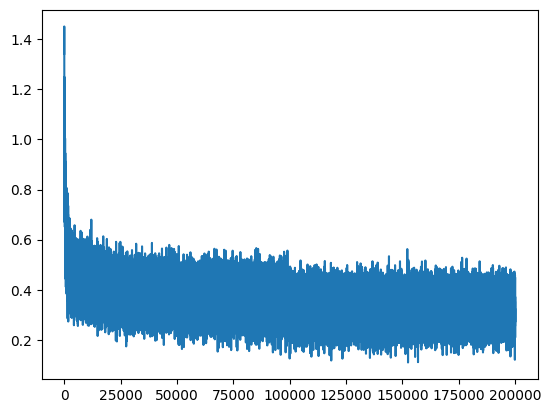

In [6]:
plt.plot(lossi)

由于每次计算损失值时使用的**小批次数据**相对于整个训练集规模较小，结果会存在较大**波动（噪声）**。


## 初始化时损失值异常偏高


训练过程总体正常，但**初始阶段的损失值异常偏高**。理论上，若每个字母出现的概率均等（即 $P=\frac{1}{46}$），则初始损失值应接近该分布的**负对数似然**：
$$-ln\left(\frac{1}{46}\right) = 3.83$$
因此，首次计算的损失值应与该数量级相当。


### 问题示例分析


为理解该问题，我们通过一个小示例观察**初始化方式**对损失值的影响。假设*logits*中所有权重初始化为0，此时输出概率将**均匀分布**。


In [7]:
logits=torch.tensor([0.0,0.0,0.0,0.0])
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

然而，**将神经网络权重初始化为0并非最佳实践**。我们采用**标准正态分布**（均值为0，方差为1）进行随机初始化。


In [8]:
logits=torch.randn(4)
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.3143, 0.0607, 0.3071, 0.3178]), tensor(2.8012))

问题显而易见：**正态分布的随机性**导致*logits*向某一侧倾斜（可多次运行上述代码验证）。解决方案：
- 将*logits*向量乘以一个**小系数**（如0.01），以降低初始权重值，使*softmax*输出更均匀。


In [9]:
logits=torch.randn(4)*0.01
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.2489, 0.2523, 0.2495, 0.2493]), tensor(1.3772))

经过调整后，损失值接近**均匀概率分布**的理论值。

**注意**：偏置项（*bias*）可初始化为0，因为初始阶段**正/负偏置缺乏实际意义**。


### 使用调整后初始化的训练


我们重用之前的代码，但采用**新的初始化参数**。


In [10]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))*0.01 # On initialise les poids à une petite valeur
b1 = torch.randn(hidden_dim) *0 # On initialise les biais à 0
W2 = torch.randn((hidden_dim, 46))*0.01
b2 = torch.randn(46)*0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [11]:
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] 
  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 
  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100000 else 0.01 
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.8304
  10000/ 200000: 2.4283
  20000/ 200000: 2.0651
  30000/ 200000: 2.1124
  40000/ 200000: 2.3158
  50000/ 200000: 2.2752
  60000/ 200000: 2.1887
  70000/ 200000: 2.1783
  80000/ 200000: 1.8120
  90000/ 200000: 2.3178
 100000/ 200000: 2.0973
 110000/ 200000: 1.8992
 120000/ 200000: 1.6917
 130000/ 200000: 2.2747
 140000/ 200000: 1.8054
 150000/ 200000: 2.3569
 160000/ 200000: 2.4231
 170000/ 200000: 2.0711
 180000/ 200000: 2.1379
 190000/ 200000: 1.8419


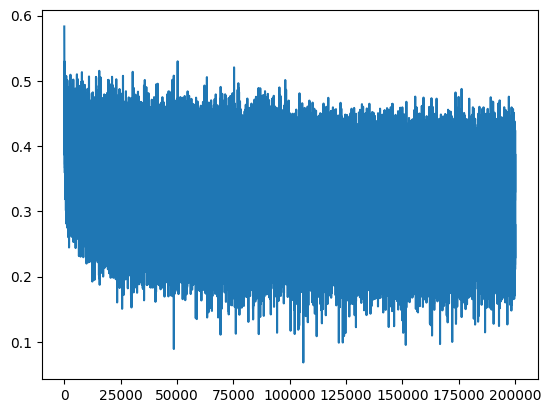

In [12]:
plt.plot(lossi)

现在，**损失曲线**不再从异常高值开始，这加速了模型的**优化过程**。


## 另一个问题


虽然高损失值似乎并非致命问题，但**不当的权重初始化**会引发其他隐患。我们以**未缩放初始化**（即未乘以0.01系数）的首轮训练为例进行分析。


In [13]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim)) 
b1 = torch.randn(hidden_dim) 
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [14]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] 
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1 
h = torch.tanh(hpreact) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yb)
  
for p in parameters:
  p.grad = None
loss.backward()

我们观察*激活函数 tanh*输出值的**直方图分布**。


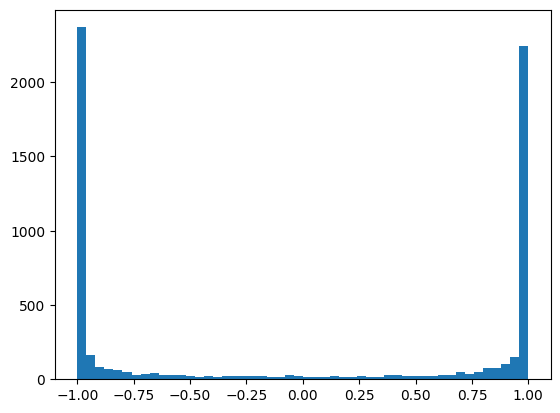

In [15]:
plt.hist(h.view(-1).tolist(),50);

观察发现，**大多数值聚集在1或-1附近**。

**问题所在**：
根据链式法则，梯度计算需逐层相乘。*tanh*函数的导数为：
$$tanh'(t) = 1 - t^2$$
当 $t$ 接近1或-1时，导数趋近于0（渐近线），导致**梯度消失**。这意味着：
- 初始阶段**梯度无法有效传播**，优化过程受阻。

我们可视化**每个神经元的激活值**以进一步分析。


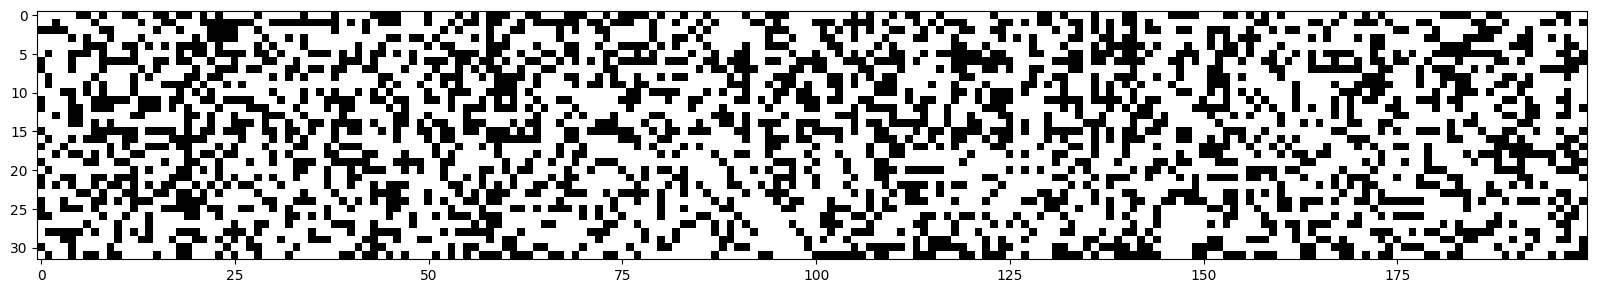

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

图中**白色点**代表梯度近似为0的神经元。

**“死神经元”**：
- 若某列全部为白色，说明该神经元在**整个批次**中均未激活，成为“**死神经元**”，对结果无贡献且无法优化。

**补充说明**：
- 该问题并非*tanh*独有：*sigmoid*与*ReLU*同样可能受此影响。
- 由于本示例模型较小，问题影响有限；但在**深度网络**中，此类问题会严重阻碍训练，需定期检查各层激活值。
- 死神经元可能出现在**初始化阶段**，或因**学习率过高**等原因在训练过程中产生。


### 如何解决该问题？


幸运的是，该问题的解决方案与**高损失值问题**相同。我们验证使用**新初始化参数**后，激活值分布与死神经元情况。


In [17]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim)) *0.01# On initialise les poids à une petite valeur
b1 = torch.randn(hidden_dim) *0 # On initialise les biais à 0
W2 = torch.randn((hidden_dim, 46)) *0.01
b2 = torch.randn(46)*0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [18]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] 
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1 
h = torch.tanh(hpreact) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yb)
  
for p in parameters:
  p.grad = None
loss.backward()

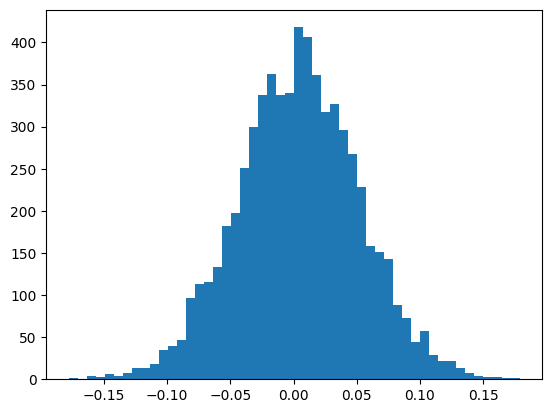

In [19]:
plt.hist(h.view(-1).tolist(),50);

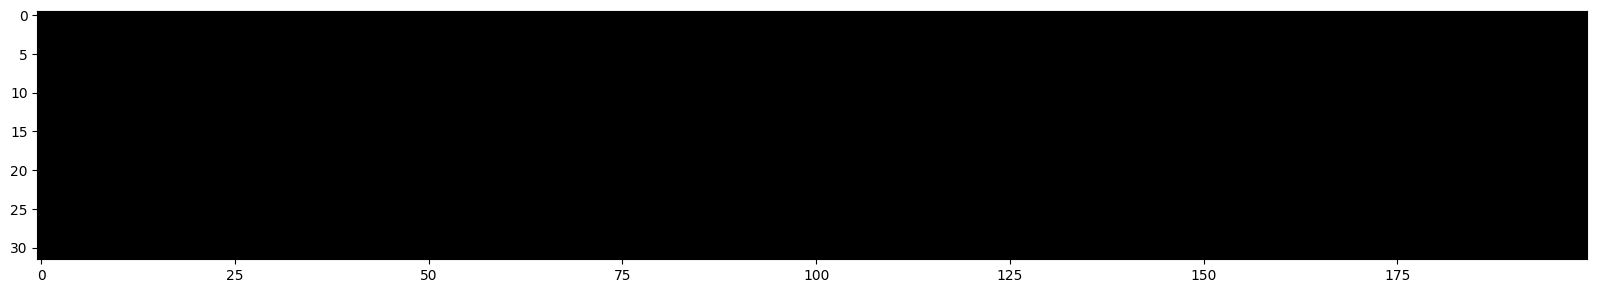

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

现在**一切正常**！


### 初始化的最优参数


由于该问题极为关键，相关研究层出不穷。其中**里程碑式论文**《[Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852)》提出了**Kaiming初始化**方法，为不同激活函数提供了**保证网络整体分布均衡**的初始化参数。

该方法已集成至[PyTorch](https://pytorch.org/docs/stable/nn.init.html)，后续创建的PyTorch层将**默认采用此初始化策略**。


### 为何将如此重要的内容放入“附录”？


该问题确实至关重要，但**使用PyTorch时**，框架已内置正确的初始化方案，通常**无需手动调整**。

此外，已有多种方法缓解该问题，如：
- **批归一化（Batch Norm）**：在下一笔记本中将详细介绍，通过**标准化激活前的值**改善梯度传播。
- **残差连接（Residual Connections）**：确保梯度能**跨层传播**，不受激活函数影响过大。

虽然理解这些原理有助于深入优化，但在**实际应用**中，PyTorch等框架的默认设置已足够支持大多数训练任务。